In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))

import geopandas as gpd
from laos_gggi import load_shapefile, load_rivers_data, load_disaster_point_data, load_synthetic_non_disaster_points
from laos_gggi.data_functions.shapefiles_data_loader import create_laos_point_grid
from laos_gggi.plotting import configure_plot_style

import matplotlib.pyplot as plt

configure_plot_style()

In [3]:
data = load_disaster_point_data()

In [4]:
world = load_shapefile('world')
laos = load_shapefile('laos')
rivers = load_rivers_data()

<Axes: >

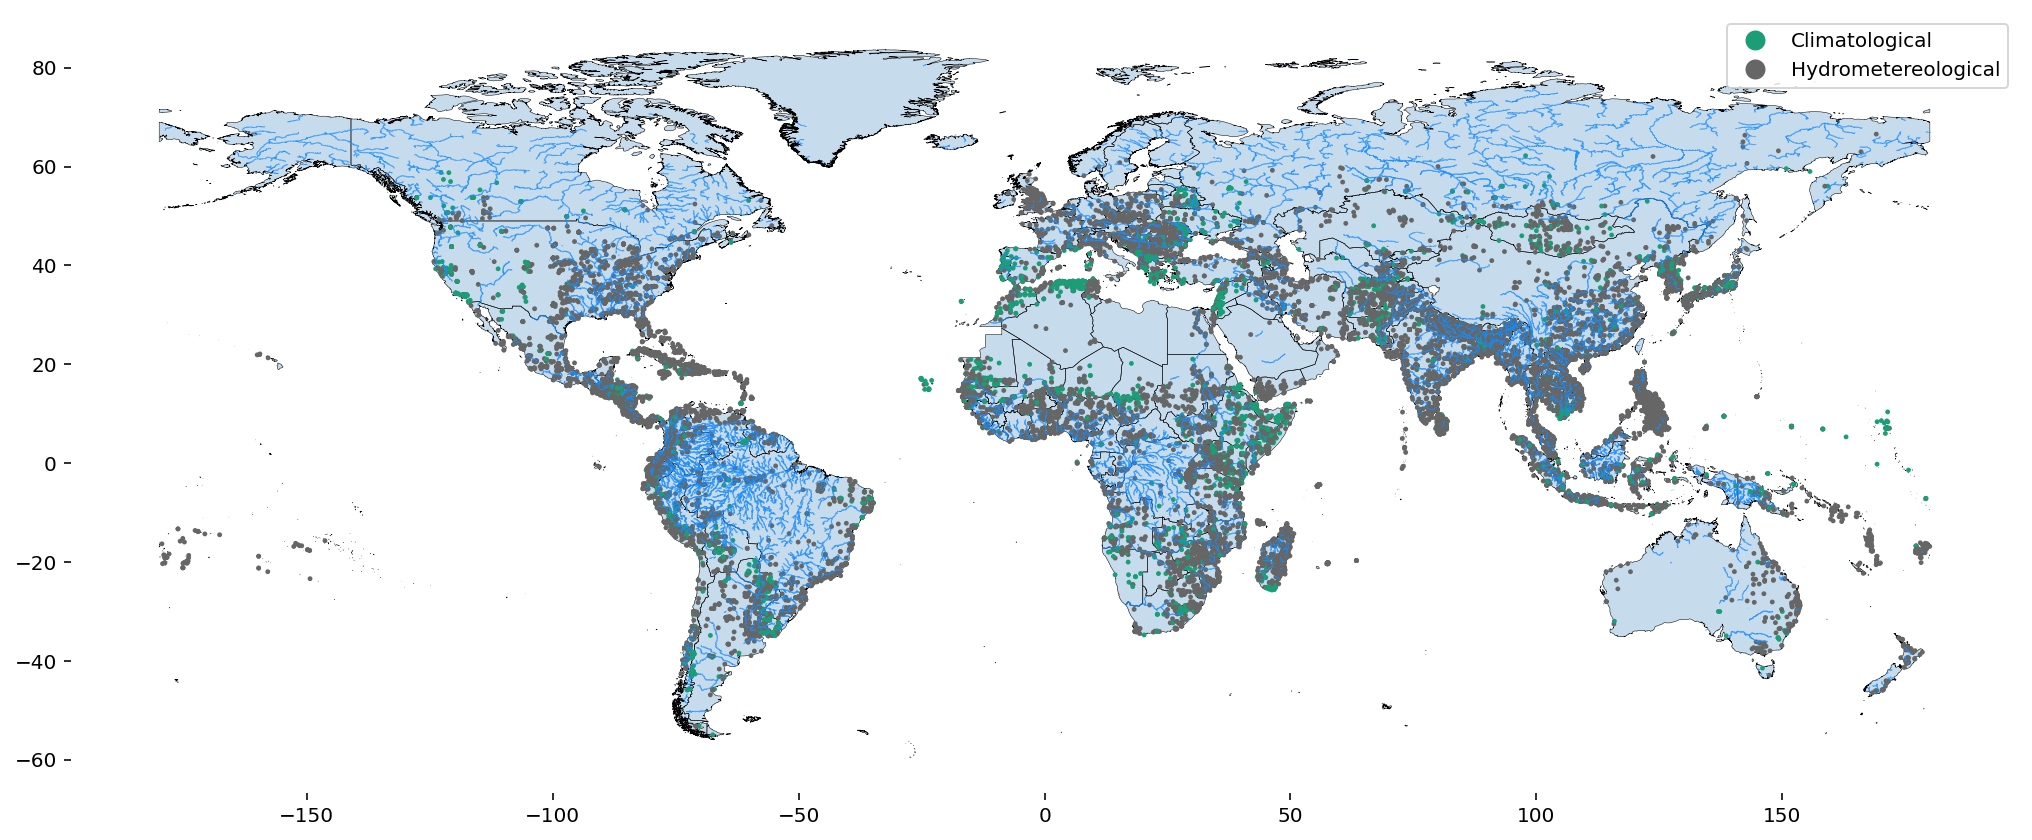

In [5]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('disaster_class', markersize=2, ax=ax, legend=True, cmap='Dark2')

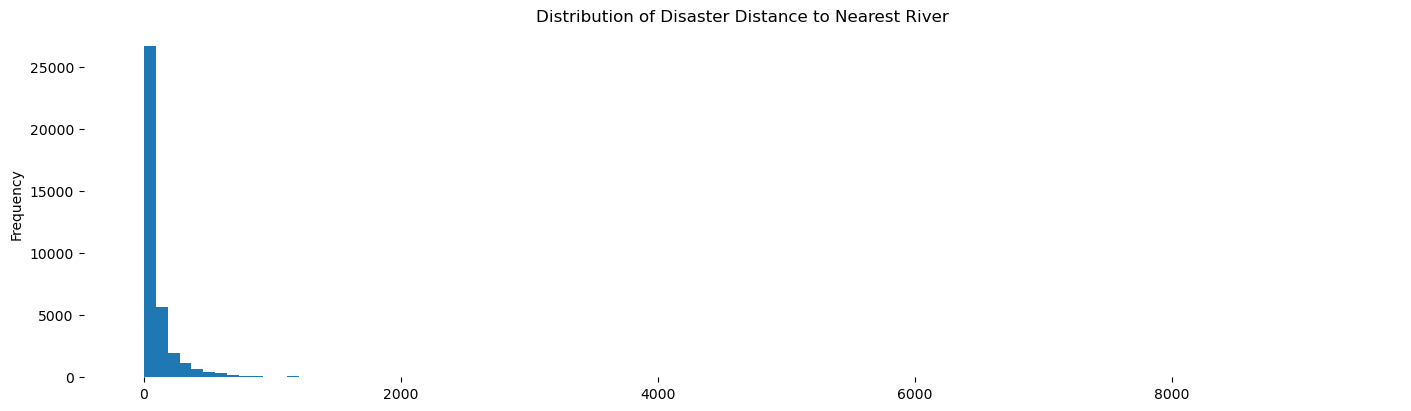

In [6]:
data.distance_to_river.plot.hist(bins=100, title='Distribution of Disaster Distance to Nearest River');

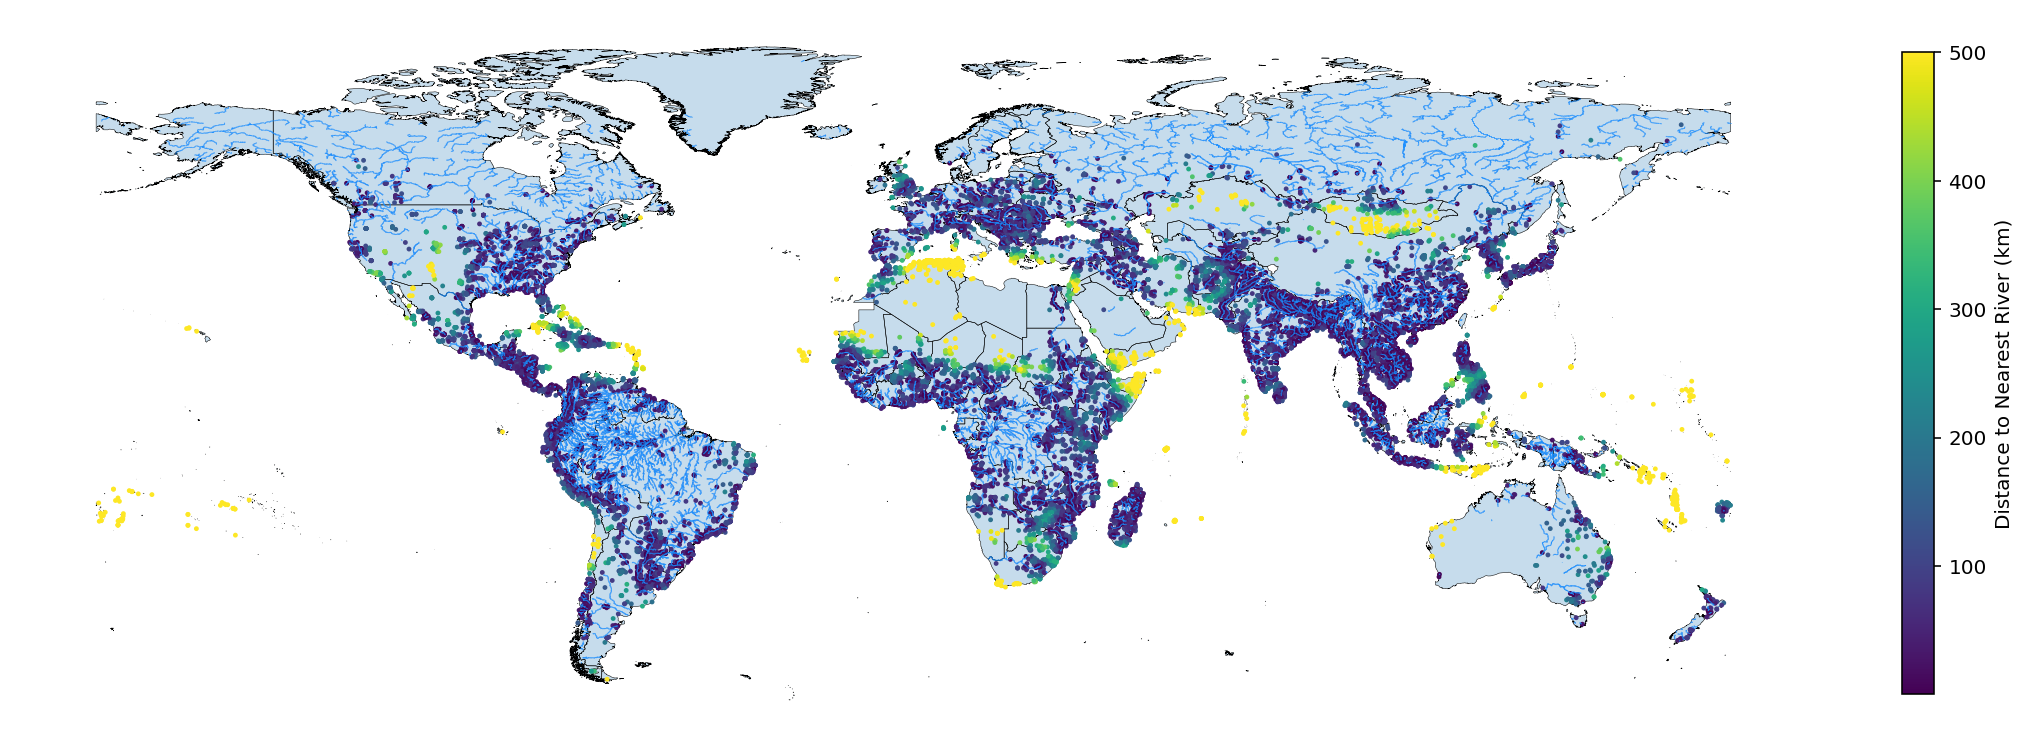

In [7]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_river', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500, 
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest River (km)'})
ax.axis('off')
plt.show()

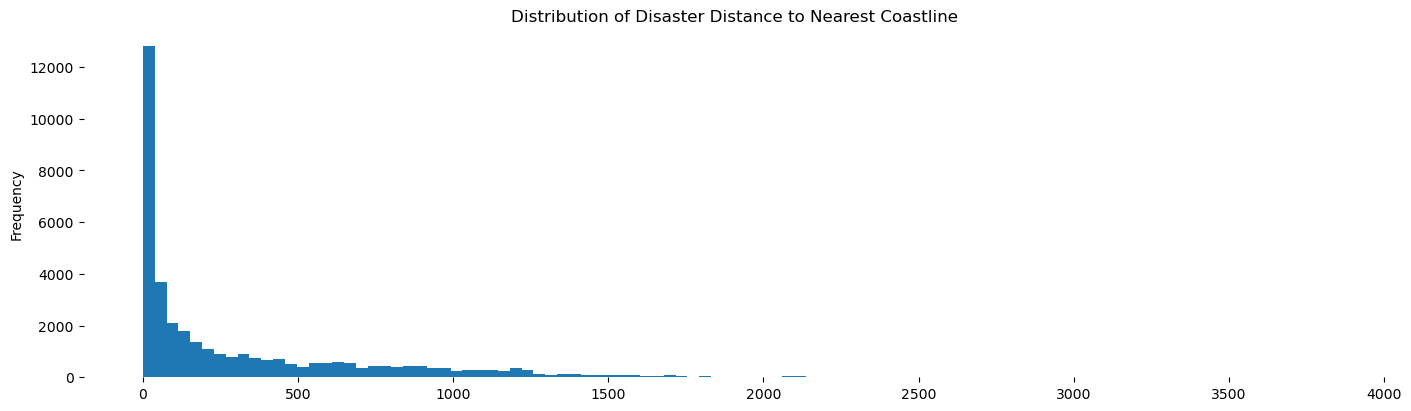

In [8]:
data.distance_to_coastline.plot.hist(bins=100, title='Distribution of Disaster Distance to Nearest Coastline');

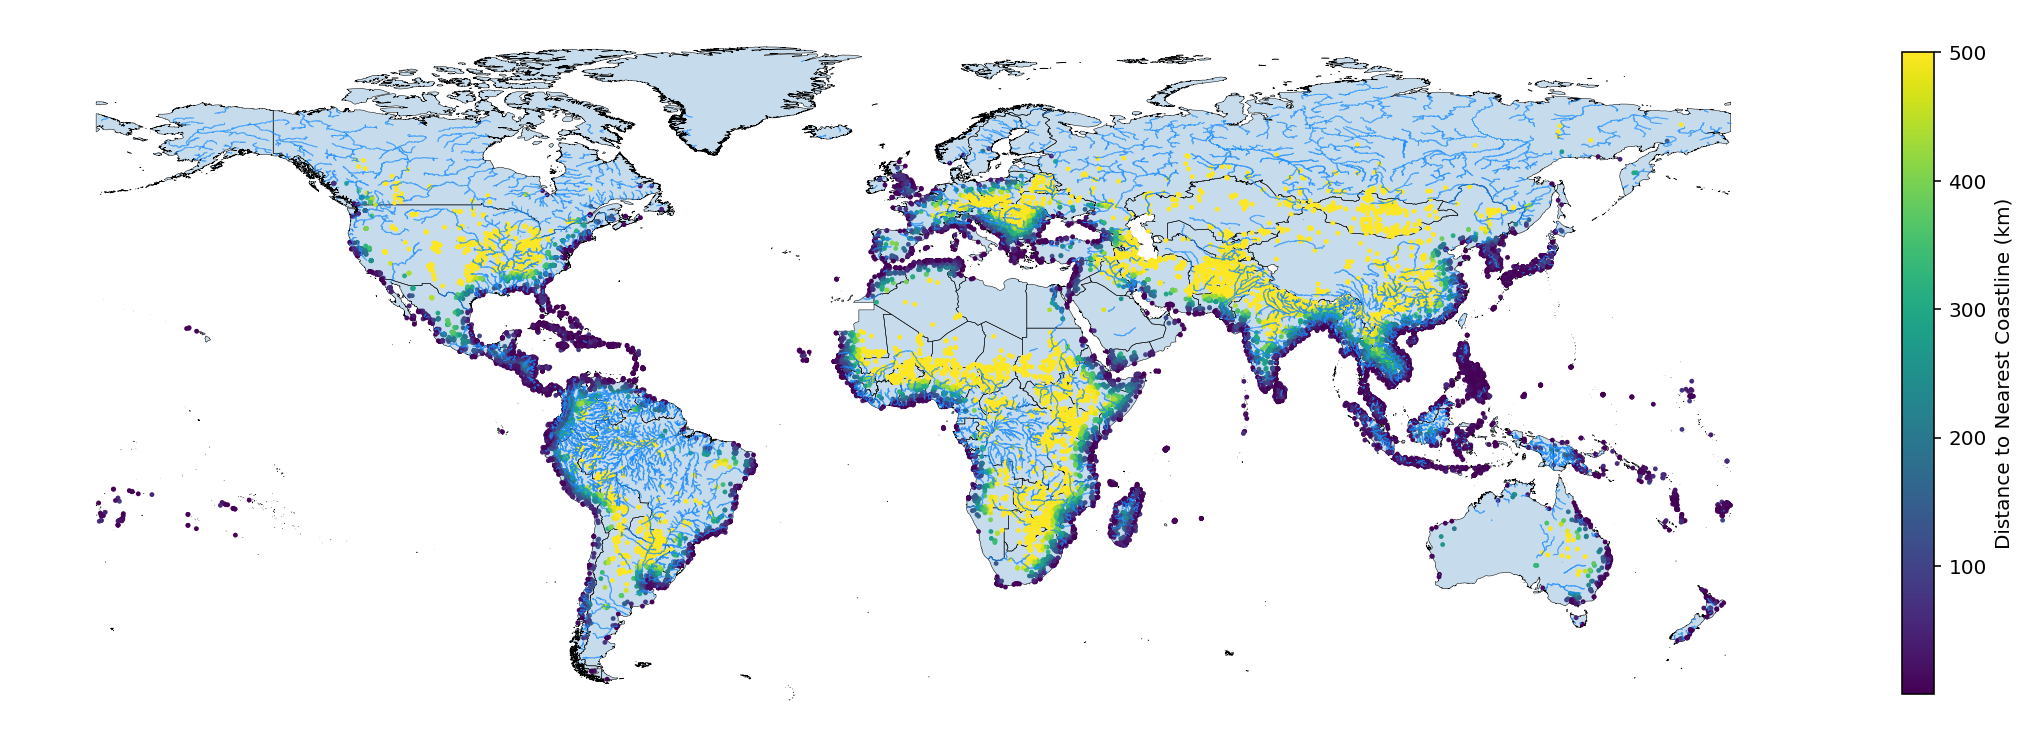

In [9]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_coastline', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500,
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest Coastline (km)'})
ax.axis('off')
plt.show()

In [10]:
island_dict = data.reset_index()[['ISO', 'is_island']].drop_duplicates().set_index('ISO')['is_island'].to_dict()

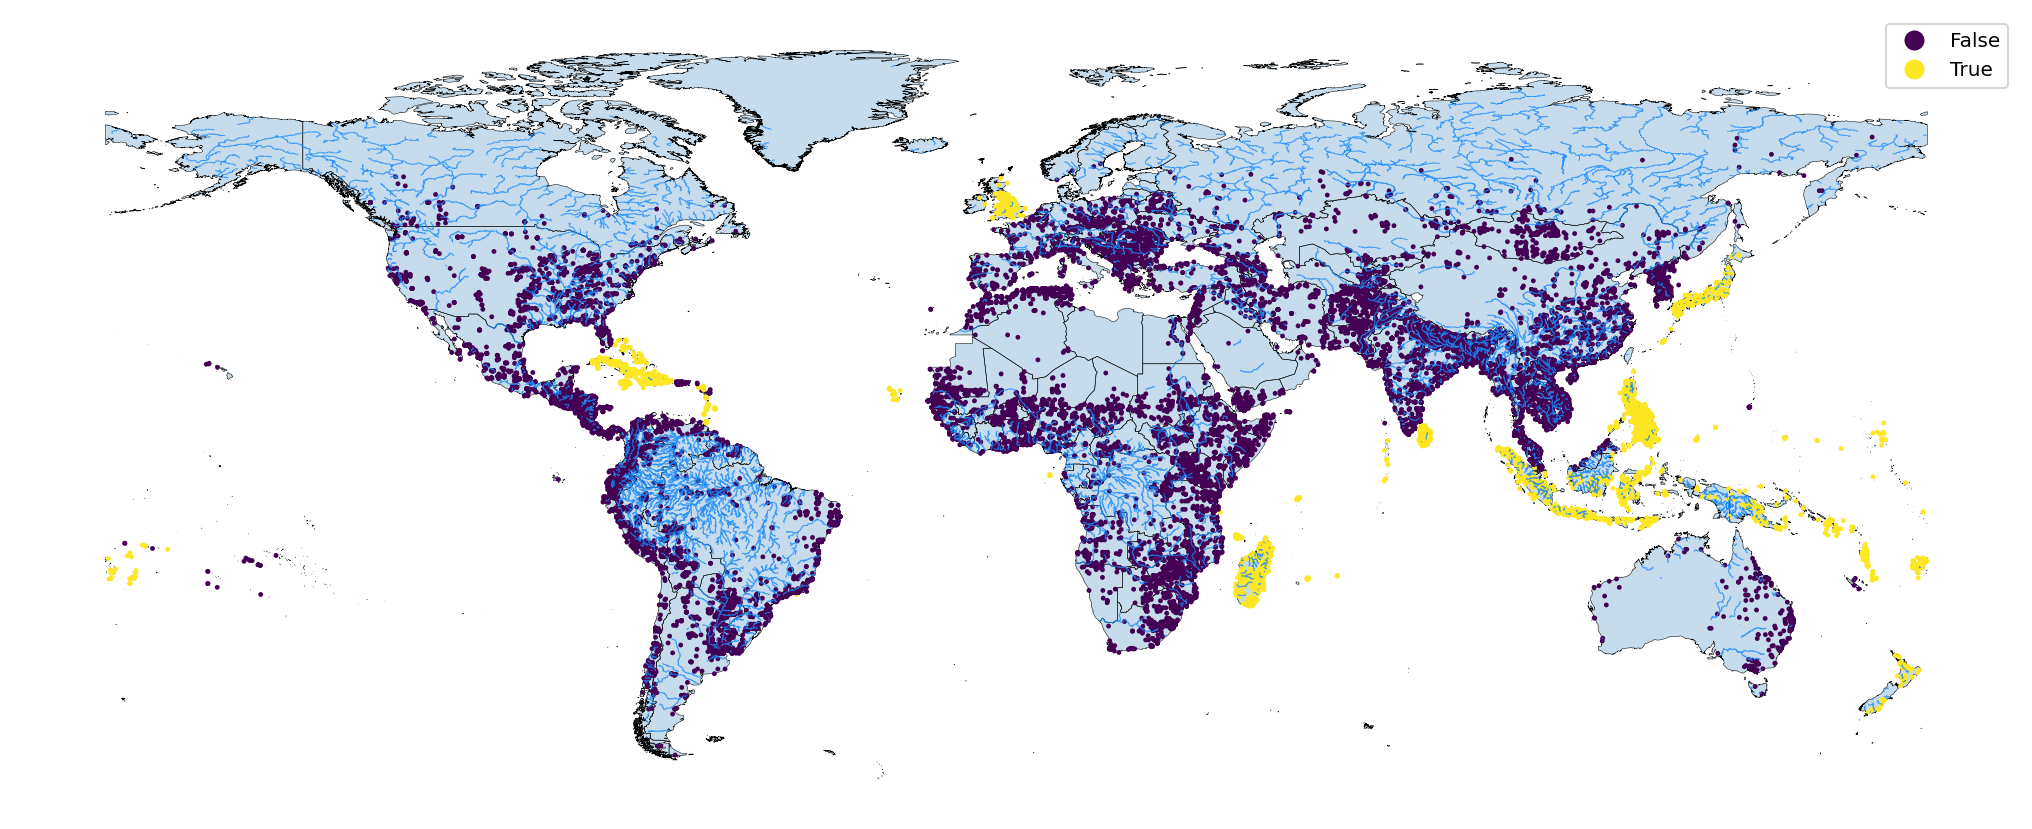

In [11]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

data.dropna(subset='disaster_class').plot('is_island', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.show()

# Synthetic Data

Create a bunch of dummy datapoints with geospatial features. These will be non-disasters. The model will need to distinguish the real disaster data from these fake points.

In [12]:
not_disasters = load_synthetic_non_disaster_points()

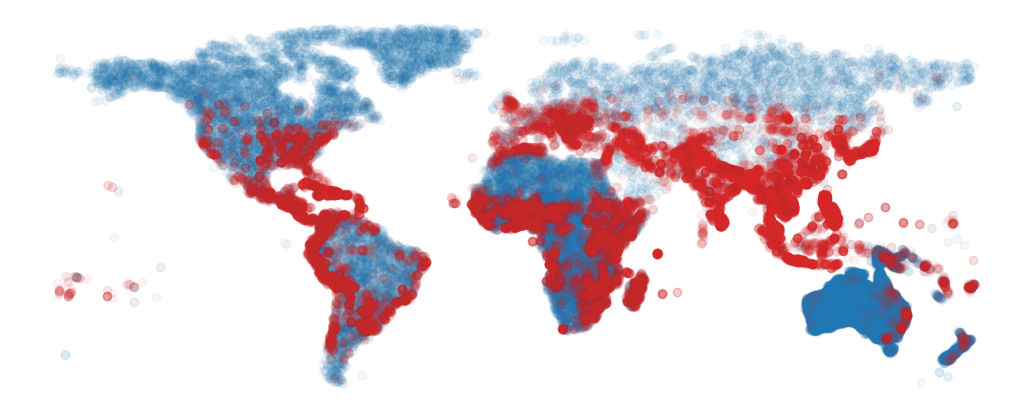

In [13]:
fig, ax = plt.subplots()
not_disasters.plot(alpha=0.05, ax=ax)
data.plot(color='tab:red', ax=ax, alpha=0.05)
ax.axis('off')
plt.show()

# Laos EDA

In [14]:
laos_grid = create_laos_point_grid()

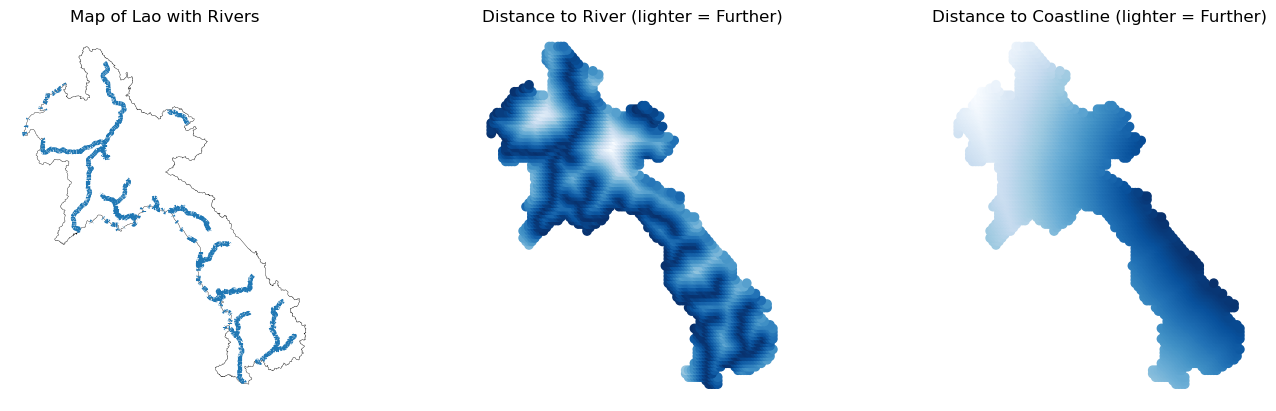

In [15]:
fig, ax = plt.subplots(1, 3,)
laos.plot(ax=ax[0], facecolor='none', edgecolor='k', lw=0.25)
gpd.sjoin(rivers, laos.dissolve(), predicate='within').plot(ax=ax[0], lw=3)
ax[0].set_title('Map of Lao with Rivers')

laos_grid.plot('distance_to_river', ax=ax[1], cmap='Blues_r')
ax[1].set_title('Distance to River (lighter = Further)')

laos_grid.plot('distance_to_coastline', ax=ax[2], cmap='Blues_r')
ax[2].set_title('Distance to Coastline (lighter = Further)')

[axis.axis('off') for axis in ax]
plt.show()

In [16]:
%%capture
try:
    from adjustText import adjust_text
except ImportError:
    !pip install adjustText
    from adjustText import adjust_text
    
import io
from contextlib import redirect_stdout

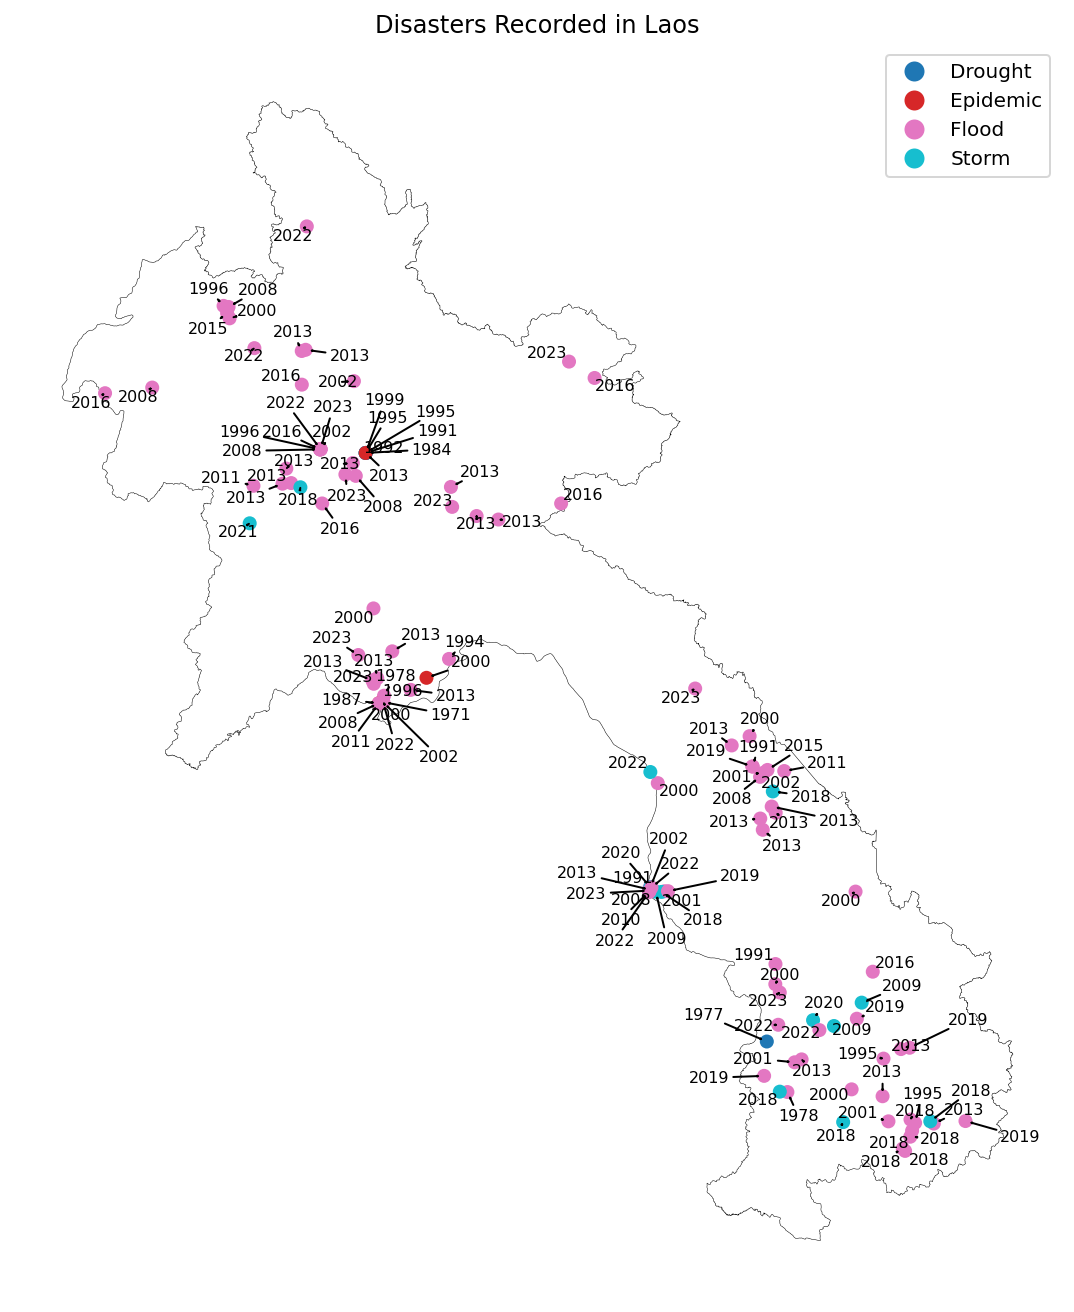

In [17]:
fig, ax = plt.subplots(figsize=(9, 9), dpi=144, subplot_kw={'aspect':'equal'})
laos.plot(ax=ax, facecolor='none', edgecolor='k', lw=0.25)

laos_disaster_points = gpd.sjoin(data, laos.dissolve(), predicate='within')
laos_disaster_points.plot('Disaster Type', ax=ax, legend=True)
texts = []
for idx, point in laos_disaster_points.iterrows():
    text = ax.text(point.long, point.lat, point.Start_Year.year, fontsize=8, ha='center', va='center')
    texts.append(text)
    

f = io.StringIO()
with redirect_stdout(f):
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k'), force_text=(0.2, 0.3))
    
ax.axis('off')
ax.set_title('Disasters Recorded in Laos')
plt.show()